In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
tel=pd.read_csv('./datasets/Telefonia_movil.csv', dtype={})

In [3]:
tel.head(5)

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
0,2013,1,8.785.943,6582117,15368060,Ene-Mar 2013
1,2013,2,9.512.689,7108640,16621329,Abr-Jun 2013
2,2013,3,10.315.484,7335154,17650638,Jul-Sept 2013
3,2013,4,9.809.515,6250549,16060064,Oct-Dic 2013
4,2014,1,10.128.751,5799223,15927974,Ene-Mar 2013


In [4]:
tel['Minutos pospago salientes (miles)']=tel['Minutos pospago salientes (miles)'].apply(lambda x: x.replace('.',''))
tel['Minutos pospago salientes (miles)']=tel['Minutos pospago salientes (miles)'].astype('int')

In [5]:
tel.head(5)

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
0,2013,1,8785943,6582117,15368060,Ene-Mar 2013
1,2013,2,9512689,7108640,16621329,Abr-Jun 2013
2,2013,3,10315484,7335154,17650638,Jul-Sept 2013
3,2013,4,9809515,6250549,16060064,Oct-Dic 2013
4,2014,1,10128751,5799223,15927974,Ene-Mar 2013


In [6]:
tel['Prd']=tel['Año'].astype(str) + 'Q' +tel['Trimestre'].astype(str) 

In [7]:
tel['Prd']

0     2013Q1
1     2013Q2
2     2013Q3
3     2013Q4
4     2014Q1
5     2014Q2
6     2014Q3
7     2014Q4
8     2015Q1
9     2015Q2
10    2015Q3
11    2015Q4
12    2016Q1
13    2016Q2
14    2016Q3
15    2016Q4
16    2017Q1
17    2017Q2
18    2017Q3
19    2017Q4
20    2018Q1
21    2018Q2
22    2018Q3
23    2018Q4
24    2019Q1
Name: Prd, dtype: object

In [8]:
tel.index=pd.PeriodIndex(tel['Prd'].values, freq='Q')

In [9]:
tel.drop(['Año','Trimestre','Prd','Total de minutos salientes (miles)','Periodo'], axis=1, inplace=True)
tel.columns=['MinPosPago','MinPrePago']

In [10]:
tel.head(5)

,MinPosPago,MinPrePago
2013Q1,8785943,6582117
2013Q2,9512689,7108640
2013Q3,10315484,7335154
2013Q4,9809515,6250549
2014Q1,10128751,5799223


In [11]:
print(tel.shape)
display(tel.head(5))
display(tel.describe())

(25, 2)


,MinPosPago,MinPrePago
2013Q1,8785943,6582117
2013Q2,9512689,7108640
2013Q3,10315484,7335154
2013Q4,9809515,6250549
2014Q1,10128751,5799223


,MinPosPago,MinPrePago
count,2.500000e+01,2.500000e+01
mean,1.235930e+07,6.562909e+06
std,2.085582e+06,5.168604e+05
min,8.785943e+06,5.380710e+06
25%,1.082146e+07,6.250549e+06
50%,1.190507e+07,6.579819e+06
75%,1.424022e+07,7.077838e+06
max,1.596076e+07,7.335154e+06


In [12]:
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

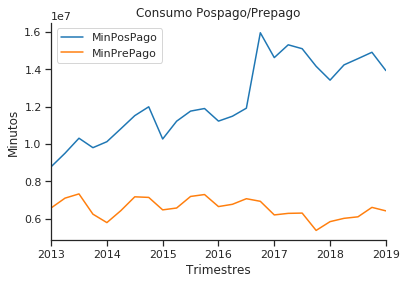

In [13]:
#sns.lineplot(data=tel, x='Periodo', y=['Minutos pospago salientes (miles)'])

ax=tel.plot()

ax.set_xlabel('Trimestres')
ax.set_ylabel('Minutos')
ax.set_title('Consumo Pospago/Prepago')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

In [14]:
#Random Walk
#Predecimos Pospago

In [15]:
tel.tail(4)

,MinPosPago,MinPrePago
2018Q2,14240217,6027374
2018Q3,14574305,6108477
2018Q4,14915060,6613685
2019Q1,13937271,6427084


In [16]:
h = 4
test = pd.period_range(start=tel.index[-1]+1, periods=h, freq='Q')

pred1=pd.Series(np.repeat(tel.MinPosPago.iloc[-1], h), index=test)
pred2=pd.Series(np.repeat(tel.MinPrePago.iloc[-1], h), index=test)

display(pred1.head(5))
display(pred2.head(5))

pred=pd.concat([pred1,pred2], axis=1)
pred.columns=['MinPosPago','MinPrePago']
pred.head()

2019Q2    13937271
2019Q3    13937271
2019Q4    13937271
2020Q1    13937271
Freq: Q-DEC, dtype: int64

2019Q2    6427084
2019Q3    6427084
2019Q4    6427084
2020Q1    6427084
Freq: Q-DEC, dtype: int64

,MinPosPago,MinPrePago
2019Q2,13937271,6427084
2019Q3,13937271,6427084
2019Q4,13937271,6427084
2020Q1,13937271,6427084


In [17]:
#Continuamos con PosPago - PRED1
pos = tel.MinPosPago

In [18]:
resid = pos - pos.shift(1) # the shift lags the series by one period
sigma = resid.std()
round(sigma,3)

1111026.926

In [19]:
intv = pd.concat([pred1-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred1-stats.norm.ppf(0.025)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv.round(3)

,0,1
2019Q2,1.175970e+07,1.611484e+07
2019Q3,1.085772e+07,1.701682e+07
2019Q4,1.016560e+07,1.770894e+07
2020Q1,9.582125e+06,1.829242e+07


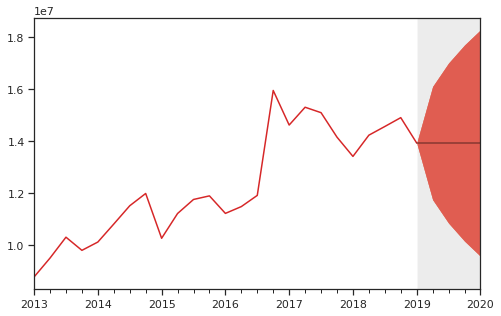

In [20]:
from plotting import fanchart

point_pred = (intv[0]+intv[1])/2

fig, ax = fanchart(pos,point_pred,intv,intv,intv)

plt.show()

In [ ]:
#Simple Exponential Smoothing

In [36]:
model_ses = sm.tsa.SimpleExpSmoothing(pos).fit()

In [39]:
fitted_ses = model_ses.fittedvalues

In [41]:
mse_ses = sm.tools.eval_measures.mse(pos,fitted_ses)
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_ses))

 In-sample fit:
 MSE               1135757362099.049


In [42]:
N = len(pos)
loglik_ses=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_ses)
aic_ses=-2*loglik_ses+2*3
bic_ses=-2*loglik_ses+np.log(N)*3
print(' Log-likelihood    %.3f' % (loglik_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))

 Log-likelihood    -382.452
 AIC               770.905
 BIC               774.562


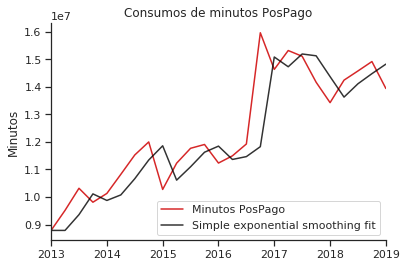

In [43]:
ax = pos.plot(color=red, label='Minutos PosPago')
fitted_ses.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Minutos')
ax.set_title('Consumos de minutos PosPago')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

In [46]:
resid = (pos - fitted_ses)/pos

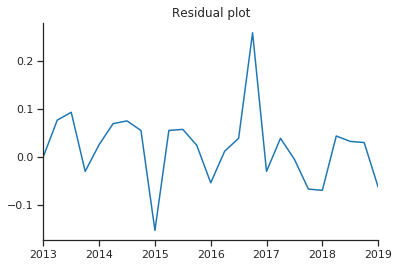

In [47]:
fig, ax = plt.subplots()
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

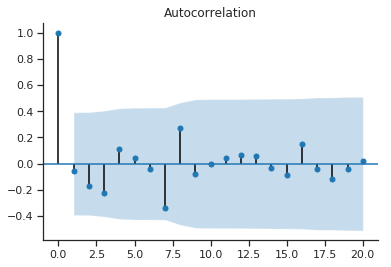

In [50]:
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(resid, lags=20, ax=ax)
sns.despine()
plt.show()

/home/marioagustin/MiniConda/envs/diplodatos/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a PeriodIndex by passing range endpoints is deprecated.  Use `pandas.period_range` instead.
  freq=base_index.freq)
/home/marioagustin/MiniConda/envs/diplodatos/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a PeriodIndex by passing range endpoints is deprecated.  Use `pandas.period_range` instead.
  freq=base_index.freq)


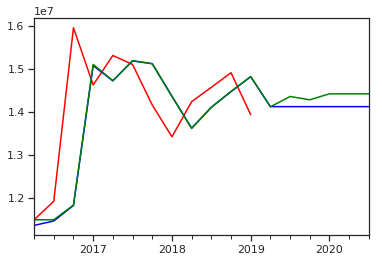

In [61]:
h=6
w=h*2
data = pos

model = sm.tsa.SimpleExpSmoothing

pred_index = pos.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)

orig_exp = None
orig_roll = None

for i in range(0,h):
    current_exp = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current_exp).fit()
    pred_expanding.update(expanding.forecast(1))
    current_roll = pd.concat([data, pred_rolling.head(i)])
    rolling = model(current_roll.tail(w)).fit()
    pred_rolling.update(rolling.forecast(1))
    
    if i==0:
        orig_fit = expanding.fittedvalues
        orig_roll = rolling.fittedvalues
        
ax = data[-w:].plot(color='red');
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_roll[-w:],pred_rolling]).plot(ax=ax,color='green');